In [135]:
import pymc
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

In [136]:
num_obs = 100


In [137]:
data_obs = np.random.poisson(1./8., size=num_obs)

In [138]:
sigma_r = np.random.normal(loc=.01, scale=.003, size=num_obs)
sigma_m = np.random.normal(loc=.8, scale=.05, size=num_obs)

m_r = np.random.normal(loc=.03, scale=.02, size=num_obs)
m_m = np.random.normal(loc=1.7, scale=.3, size=num_obs)

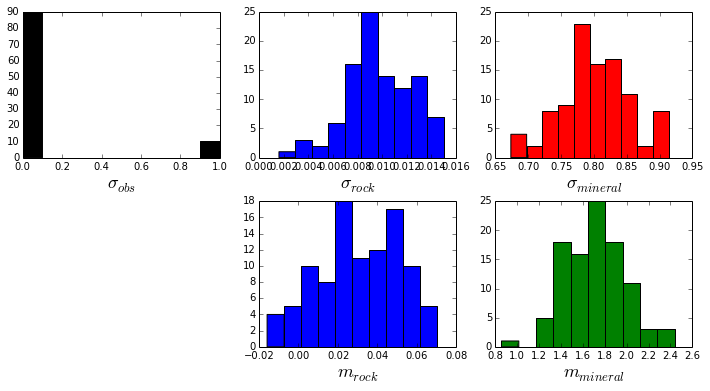

In [139]:
fig = plt.figure(1, [12, 6], dpi=300)
fig.subplots_adjust(hspace=.3)
ax1 = fig.add_subplot(2,3,1)
counts, bins, ignored = ax1.hist(data_obs, normed=False, color='black')
ax1.set_xlabel(r'$\sigma_{obs}$', fontdict={'size':18})

ax2 = fig.add_subplot(2,3,2)
counts, bins, ignored = ax2.hist(sigma_r, normed=False, color='blue')
ax2.set_xlabel(r'$\sigma_{rock}$', fontdict={'size':18})

ax3 = fig.add_subplot(2,3,3)
counts, bins, ignored = ax3.hist(sigma_m, normed=False, color='red')
ax3.set_xlabel(r'$\sigma_{mineral}$', fontdict={'size':18})

ax6 = fig.add_subplot(2,3,5)
counts, bins, ignored = ax6.hist(m_r, normed=False, color='blue')
ax6.set_xlabel(r'$m_{rock}$', fontdict={'size':18})

ax8 = fig.add_subplot(2,3,6)
counts, bins, ignored = ax8.hist(m_m, normed=False, color='green')
ax8.set_xlabel(r'$m_{mineral}$', fontdict={'size':18})
plt.show()

In [140]:

    
# prior information of unknown model parameters
phi_r = pymc.Normal('phi_r', .7, .2)
phi_m = pymc.Normal('phi_m', .1, .1)

# expected outcome is governed by Archies equation of Glove 2010
@pymc.deterministic
def archies(s_r=sigma_r, s_m=sigma_m, 
            p_r=phi_r, p_m=phi_m, 
            m_r=m_r, m_m=m_m):
    archie_return = (s_r*p_r**m_r)+(s_m*p_m**m_m)
    return archie_return


# likelihood of the observations is a normal distribution
# and is the data itself
sigma_obs = pymc.Normal('sigma_obs', mu=archies, value=data_obs, observed=True)

archie_model = pymc.Model([archies, sigma_r, sigma_m, 
                           phi_r, phi_m, 
                           m_r, m_m, 
                           sigma_obs, 
                           data_obs])


C:\Python27\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in power


In [141]:
model_fit = pymc.MCMC(archie_model)
model_fit.sample(iter=10000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.8 sec

C:\Python27\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in power


             Rock   Mineral
Mean Percent   0.79   0.38
Median Percent 0.80   0.37
Mode Percent   0.65   0.39
Min Percent    0.54   0.00
Max Percent    1.00   1.00
STD            0.13   0.24


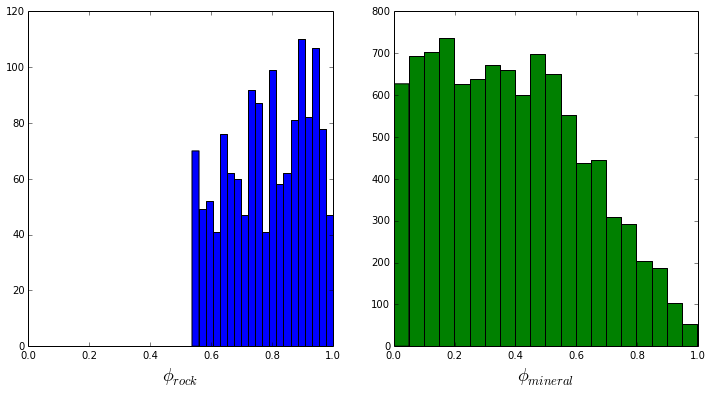

In [142]:
pr_arr = model_fit.trace('phi_r')[:]
pm_arr = model_fit.trace('phi_m')[:]

pr_arr = pr_arr[np.where((pr_arr>=0)& (pr_arr<=1))]
pm_arr = pm_arr[np.where((pm_arr>=0)& (pm_arr<=1))]

# make sure that the rock percentage is confined to values where the 
# total proportion is equal to 1
pr_arr = pr_arr[np.where(pr_arr > 1-(stats.mode(pm_arr)[0][0])*1.2)]

fig_2 = plt.figure(2, [12, 6], dpi=300)
ax1 = fig_2.add_subplot(1, 2, 1)
h1 = ax1.hist(pr_arr, bins=20, color='blue')
ax1.set_xlim(0, 1)
ax1.set_xlabel(r'$\phi_{rock}$', fontdict={'size':18})


ax3 = fig_2.add_subplot(1, 2, 2)
h3 = ax3.hist(pm_arr, bins=20, color='green')
ax3.set_xlim(0, 1)
ax3.set_xlabel(r'$\phi_{mineral}$', fontdict={'size':18})


print '             Rock   Mineral'
print 'Mean Percent   {0:.2f}   {1:.2f}'.format(pr_arr.mean(),
                                                pm_arr.mean())
print 'Median Percent {0:.2f}   {1:.2f}'.format(np.median(pr_arr),
                                                np.median(pm_arr))
print 'Mode Percent   {0:.2f}   {1:.2f}'.format(stats.mode(pr_arr)[0][0],
                                                stats.mode(pm_arr)[0][0])
print 'Min Percent    {0:.2f}   {1:.2f}'.format(pr_arr.min(),
                                                pm_arr.min())
print 'Max Percent    {0:.2f}   {1:.2f}'.format(pr_arr.max(),
                                                pm_arr.max())
print 'STD            {0:.2f}   {1:.2f}'.format(pr_arr.std(),
                                                pm_arr.std()) 